

# Drowsiness Detection System
## Using Pre-trained Mobilenet_v2 model


## Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Loading Data

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (300, 300)

In [ ]:
train_dir = '/content/drive/MyDrive/Drowsiness Detection System Dataset'

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


## Splitting Dataset

In [ ]:
train_batches = tf.data.experimental.cardinality(train_dataset) # Counting the no. of batches in the train_dataset
valid_data = train_dataset.take(train_batches//3) # Taking one third of the train dataset as valid dataset
train_data = train_dataset.skip(train_batches//3) # Skipping the data in valid dataset in actual training dataset

In [ ]:
print(train_batches)

tf.Tensor(63, shape=(), dtype=int64)


In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_data))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_data))

Number of validation batches: 21
Number of train batches: 42


## Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Resizing(224,224), # Resizing the images to (224, 224)
  tf.keras.layers.RandomFlip('horizontal'), # flipping the images horizontally
  tf.keras.layers.RandomRotation(0.2), # Rotating the images
])

## Processing Data

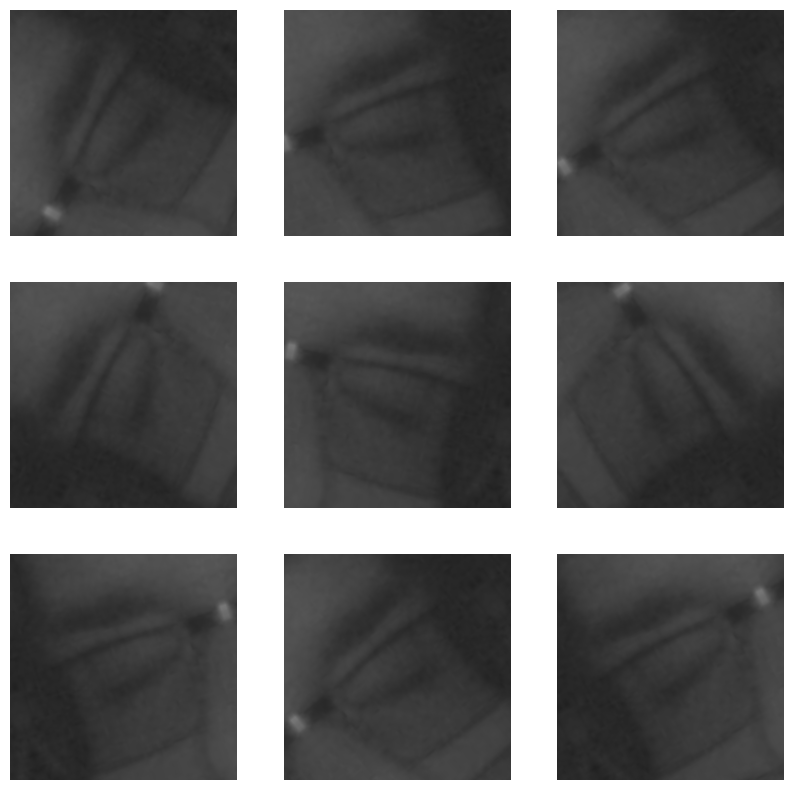

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # Preprocessing layer of mobilenet_v2 model

## Loading and Tuning Pre-trained Model

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


### Making layers non-trainable

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

### Adding Classification head

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [ ]:
inputs = tf.keras.Input(shape=(300, 300, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compiling model

In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

### Training the model

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(valid_data)

21/21 [==============================] - 83s 4s/step - loss: 0.8801 - accuracy: 0.5193


In [ ]:
history = model.fit(
    train_data,
    epochs=initial_epochs,
    validation_data=valid_data)

Epoch 1/10
42/42 [==============================] - 132s 3s/step - loss: 0.7408 - accuracy: 0.5700 - val_loss: 0.5675 - val_accuracy: 0.8036
Epoch 2/10
42/42 [==============================] - 6s 116ms/step - loss: 0.4959 - accuracy: 0.8057 - val_loss: 0.4205 - val_accuracy: 0.9048
Epoch 3/10
42/42 [==============================] - 8s 145ms/step - loss: 0.3745 - accuracy: 0.8893 - val_loss: 0.3226 - val_accuracy: 0.9420
Epoch 4/10
42/42 [==============================] - 7s 133ms/step - loss: 0.2885 - accuracy: 0.9285 - val_loss: 0.2558 - val_accuracy: 0.9792
Epoch 5/10
42/42 [==============================] - 6s 113ms/step - loss: 0.2321 - accuracy: 0.9511 - val_loss: 0.2136 - val_accuracy: 0.9807
Epoch 6/10
42/42 [==============================] - 7s 114ms/step - loss: 0.1909 - accuracy: 0.9684 - val_loss: 0.1773 - val_accuracy: 0.9836
Epoch 7/10
42/42 [==============================] - 7s 125ms/step - loss: 0.1603 - accuracy: 0.9714 - val_loss: 0.1618 - val_accuracy: 0.9807
Epoch 8

### Evaluating the model

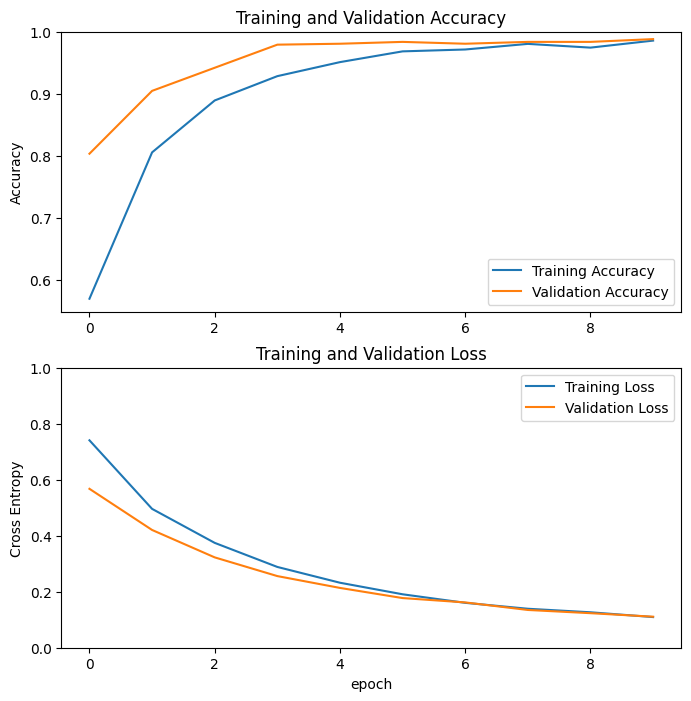

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Testing the model

In [ ]:
class_names = ['closed_eyes', 'open_eyes']

In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/datasets/Drowsiness Detection System Dataset/test",
                                                            shuffle=True,
                                                            batch_size=10,
                                                            image_size=IMG_SIZE)

Found 10 files belonging to 2 classes.


Predictions:
 [0 0 1 0 1 1 0 1 1 0]
Labels:
 [0 0 1 0 1 1 0 1 1 0]


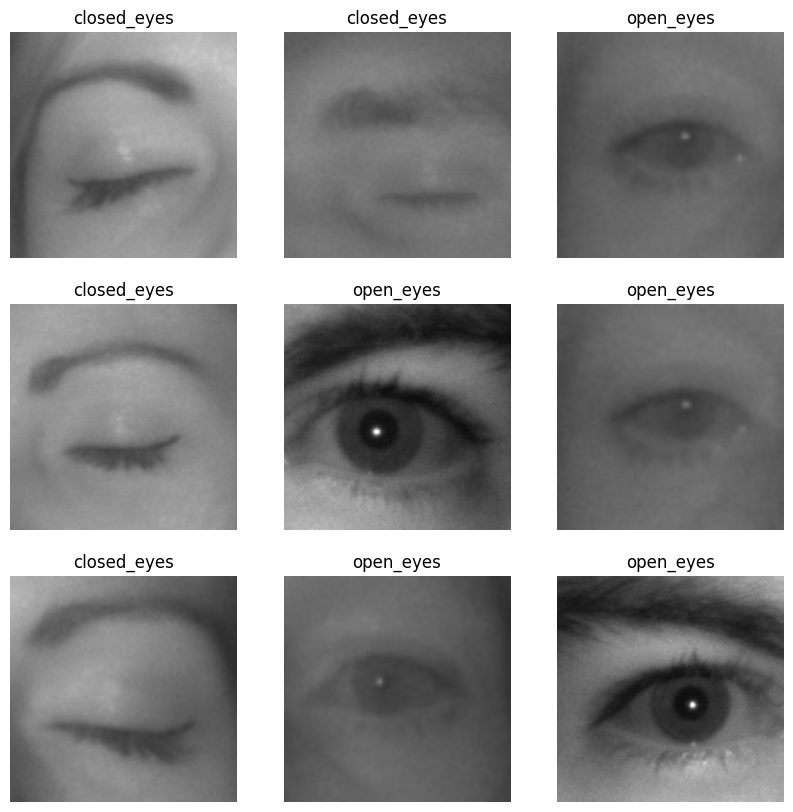

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

### Saving the model

In [ ]:
model.save('/content/drive/MyDrive/AI projects/Drowsiness Detection/model')